# 라이브러리

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import torch
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# 데이터

## 데이터 경로

In [2]:
# [1] 구글 드라이브 마운트 및 경로 설정
print("Mounting Google Drive...")
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/Kaggle/csiro-biomass'

# 파일 경로 설정
train_csv_path = os.path.join(root_path, 'train.csv')
test_csv_path = os.path.join(root_path, 'test.csv')

train_img_dir = os.path.join(root_path, 'train')

# GPU 설정
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'CUDA' if device==0 else 'CPU'}")

# 데이터 로드
print(f"Loading csv data from {root_path}...")

if os.path.exists(train_csv_path):
    df_train_raw = pd.read_csv(train_csv_path)
    df_test_raw = pd.read_csv(test_csv_path)
    print("Train/Test CSV loaded successfully.")
else:
    print(f"Error: Files not found at {root_path}")

print(f"Train Image Directory: {train_img_dir}")

Mounting Google Drive...
Mounted at /content/drive
Using device: CUDA
Loading csv data from /content/drive/MyDrive/Kaggle/csiro-biomass...
Train/Test CSV loaded successfully.
Train Image Directory: /content/drive/MyDrive/Kaggle/csiro-biomass/train


In [3]:
for dirname, _, filenames in os.walk(root_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Kaggle/csiro-biomass/test.csv
/content/drive/MyDrive/Kaggle/csiro-biomass/train.csv
/content/drive/MyDrive/Kaggle/csiro-biomass/sample_submission.csv
/content/drive/MyDrive/Kaggle/csiro-biomass/.DS_Store
/content/drive/MyDrive/Kaggle/csiro-biomass/submission_final.csv
/content/drive/MyDrive/Kaggle/csiro-biomass/dino_submission.csv
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1012260530.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1025234388.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1011485656.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1051144034.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1035947949.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1036339023.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1028611175.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1049634115.jpg
/content/drive/MyDrive/Kaggle/csiro-biomass/train/ID1052620238.jpg
/content/drive/MyDrive/Kaggle/csiro-bioma

## 데이터 로드

### csv

In [4]:
data = pd.read_csv(train_csv_path)
data.head()

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [5]:
data["image_id"]=data["image_path"].str[6:]
image_info = data[["Sampling_Date", "State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm", "image_id"]].copy().drop_duplicates().reset_index(drop=True)
images_target = data.pivot(index="image_id", columns="target_name", values="target").reset_index()
image_info = image_info.merge(images_target, on="image_id")
image_info = image_info[['image_id', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm',
                         'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']]
image_info.drop(columns=["Sampling_Date", "State"], inplace=True)
image_info.head()

,image_id,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,ID1011485656.jpg,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,ID1012260530.jpg,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,ID1025234388.jpg,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,ID1028611175.jpg,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,ID1035947949.jpg,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


### image

In [6]:
# 전체 이미지 경로 컬럼 생성
image_info['full_path'] = image_info['image_id'].apply(lambda x: os.path.join(train_img_dir, x))

총 이미지 개수: 357
--------------------------------------------------
이미지 ID: ID1011485656.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3


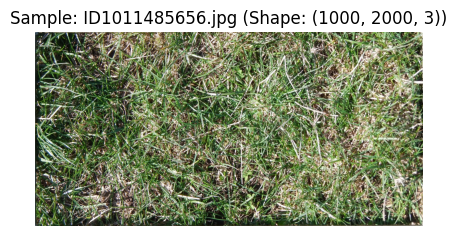

이미지 ID: ID1012260530.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1025234388.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1028611175.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
이미지 ID: ID1035947949.jpg
  - 크기(Shape): (1000, 2000, 3)
  - 높이(H): 1000, 너비(W): 2000
  - 채널(C): 3
--------------------------------------------------


In [7]:
# 이미지 기본 정보 확인 (크기, 채널)
print(f"총 이미지 개수: {len(image_info)}")
print("-" * 50)

# 처음 5개 이미지만 샘플로 확인
sample_images = image_info.head(5)

for idx, row in sample_images.iterrows():
    path = row['full_path']
    img = cv2.imread(path)

    if img is None:
        print(f"[Error] 이미지를 찾을 수 없습니다: {path}")
        continue

    # OpenCV는 BGR로 읽으므로 RGB로 변환 (시각화를 위해)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # shape 출력: (Height, Width, Channel)
    print(f"이미지 ID: {row['image_id']}")
    print(f"  - 크기(Shape): {img.shape}")
    print(f"  - 높이(H): {img.shape[0]}, 너비(W): {img.shape[1]}")
    print(f"  - 채널(C): {img.shape[2]}") # 3이면 RGB, 4면 RGBA

    # 이미지 시각화 (첫 번째만)
    if idx == 0:
        plt.figure(figsize=(5, 5))
        plt.imshow(img_rgb)
        plt.title(f"Sample: {row['image_id']} (Shape: {img.shape})")
        plt.axis('off')
        plt.show()

print("-" * 50)

---

## 분석 목표
NDVI와 Height_Ave_cm을 이미지로부터 예측하기  
이미지 특성을 파악하고 어떻게 예측할 수 있을지 살펴봄

## 전처리 함수

In [8]:
def get_features_from_path(path, image_id):
    """
    이미지 경로 하나를 받아서, 로드 -> 전처리 -> 특징 추출 후
    딕셔너리(Row) 형태로 반환하는 함수
    """
    # I. 이미지 로드 및 2가지 전처리
    # I-A. Img_Raw
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        return None
    img_raw = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # I-B. Img_Norm (정규화 RGB)
    img_float = img_raw.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True)
    img_norm = img_float / (sum_rgb + 1.0)

    # I-C. Img_Tex (CLAHE Grayscale)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_tex = clahe.apply(gray) # CLAHE 적용


    # II. 마스크 생성
    # II-A. Mask_Green (ExG)
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 어느정도까지를 green마스크로 지정할것인지는 직접 확인해봐야함
    _, mask_green = cv2.threshold(exg, 0, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)

    # II-B. Mask_Dead (HSV 갈색 범위)
    ### 예시는 노랑 ~ 갈색이지만 실제 이미지를 보고 색생을 스포이드로 찍어본 후 판단해주세요
    hsv = cv2.cvtColor(img_raw, cv2.COLOR_RGB2HSV)
    mask_dead = cv2.inRange(hsv, (15, 30, 30), (35, 255, 255)) #H: 15~35, S와 V: 적당히

    # II-C. Mask_Shadow (밝기 하위 20%)
    mask_shadow = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40)) # V < 40

    # III. 특징 추출
    features = {'image_id': image_id}

    # III-A. 면적 계산
    plant_area = cv2.countNonZero(mask_green)
    features['Green_Pixel_Count'] = plant_area
    features['Dead_Pixel_Count'] = cv2.countNonZero(mask_dead)
    ### 그림자 비율
    area_green = cv2.countNonZero(mask_green)
    area_shadow = cv2.countNonZero(mask_shadow)
    if area_green > 0:
        # 초록색 잎 1픽셀당 그림자가 몇 픽셀이나 생겼는가? #흙에 의한 그림자는 그냥 넘어간다
        features['Shadow_Green_Ratio'] = area_shadow / area_green
    else:
        features['Shadow_Green_Ratio'] = 0
    features['Shadow_Pixel_Count'] = area_shadow #그림자의 절대적인 양도 추가

    # III-B. 식생 지수 - NDVI

    if plant_area > 0:
        features['Avg_Greenness'] = cv2.mean(g, mask=mask_green)[0]
        features['Avg_ExG'] = cv2.mean(exg, mask=mask_green)[0]
    else:
        features['Avg_Greenness'] = 0
        features['Avg_ExG'] = 0

    return features

In [9]:
final_data = []
image_paths = image_info['full_path'].values
image_ids = image_info['image_id'].values

In [10]:
for path, img_id in tqdm(zip(image_paths, image_ids), total=len(image_paths)):
    try:
        # 하나 처리하고 결과만 받기 (이미지는 메모리에 안 남음)
        row_data = get_features_from_path(path, img_id)

        if row_data is not None:
            final_data.append(row_data)

    except Exception as e:
        print(f"Error processing {img_id}: {e}")

# 데이터프레임 변환
image_features = pd.DataFrame(final_data)
print("\n분석 완료!")
print(image_features.head())

100%|██████████| 357/357 [01:06<00:00,  5.34it/s]


분석 완료!
           image_id  Green_Pixel_Count  Dead_Pixel_Count  Shadow_Green_Ratio  \
0  ID1011485656.jpg            1818172            586734            0.112949   
1  ID1012260530.jpg             973970            369968            0.452069   
2  ID1025234388.jpg            1127904            246418            0.270286   
3  ID1028611175.jpg            1939264            555942            0.060576   
4  ID1035947949.jpg            1968021           1414487            0.061309   

   Shadow_Pixel_Count  Avg_Greenness   Avg_ExG  
0              205361       0.413615  0.246557  
1              440302       0.380131  0.145856  
2              304857       0.383265  0.155432  
3              117473       0.451829  0.361015  
4              120657       0.413059  0.244302  


---

## 1. 이미지 전처리 - 이미지 시각화 (세가지 버전)

In [11]:
def get_images_for_viz(path):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print(f"Error: 이미지를 찾을 수 없습니다 -> {path}")
        return None, None, None
    img_raw = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 정규화
    img_float = img_raw.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True)
    img_norm = img_float / (sum_rgb + 1.0)

    # 텍스처 (CLAHE)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_tex = clahe.apply(gray)

    return img_raw, img_norm, img_tex

In [12]:
# 이미지 한장에 대해 세가지 버전으로 출력 시각화
def image_plot(idx):
    # 1. 이미지 한 장 로드
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    # 2. 그림 그리기 준비
    fig = plt.figure(figsize=(15, 5))

    # (1) 원본
    plt.subplot(1, 3, 1)
    plt.imshow(img_raw)
    plt.axis('off')

    # (2) 정규화
    plt.subplot(1, 3, 2)
    plt.imshow(img_norm)
    plt.axis('off')

    # (3) 텍스처
    plt.subplot(1, 3, 3)
    plt.imshow(img_tex, cmap='gray')
    plt.axis('off')

    plt.show()

    # 3. 메모리 해제
    plt.close(fig) # 필수: 이거 안 하면 램 터짐

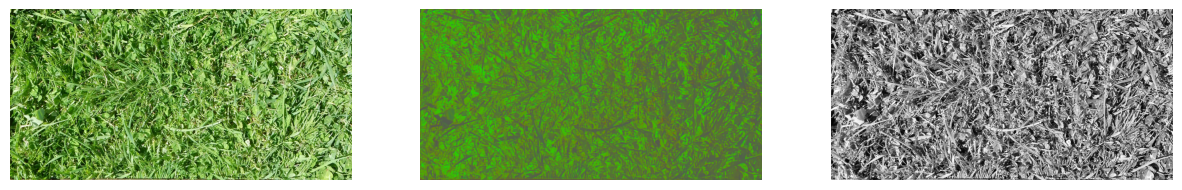

In [13]:
#이미지 출력
image_plot(5) #인덱스를 넣기

## 2. Mask 생성 - green, dead, shadow mask 시각화

In [33]:
def image_masks_plot(idx):
    # 1. 이미지 한장 로드
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    # II. 마스크 생성
    # II-A. Mask_Green (ExG)
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 어느정도까지를 green마스크로 지정할것인지는 직접 확인해봐야함
    _, mask_green = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)


    # II-B. Mask_Dead (HSV 갈색 범위)
    ### 예시는 노랑 ~ 갈색이지만 실제 이미지를 보고 색생을 스포이드로 찍어본 후 판단해주세요
    hsv = cv2.cvtColor(img_raw, cv2.COLOR_RGB2HSV)
    mask_dead = cv2.inRange(hsv, (15, 30, 30), (35, 255, 255)) #H: 15~35, S와 V: 적당히

    # II-C. Mask_Shadow (밝기 하위 20%)
    mask_shadow_raw = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40)) # V < 40
    ## 식물 영역 부풀리기 (Dilation)
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)) #부풀림 정도
    mask_green_dilated = cv2.dilate(mask_green, dilation_kernel, iterations=1)
    ## 교집합 구하기 (전체 그림자 AND 부풀린 식물 영역)
    ## 결과: 흙 그림자는 빠지고, 식물 근처 그림자만 남음
    mask_shadow = cv2.bitwise_and(mask_shadow_raw, mask_green_dilated)

#########################
    # 2. 그림 그리기 준비
    fig = plt.figure(figsize=(20, 5))

    # (0) 원본 (비교를 위해 추가하면 좋습니다)
    plt.subplot(1, 4, 1)
    plt.imshow(img_raw)
    plt.title(f"Original (idx: {idx})")
    plt.axis('off')

    # (1) Green Mask
    plt.subplot(1, 4, 2)
    plt.imshow(mask_green, cmap='gray')
    plt.title("Mask Green (ExG > 0)")
    plt.axis('off')


    # (2) Shadow Mask
    plt.subplot(1, 4, 3)
    plt.imshow(mask_shadow, cmap='gray')
    plt.title("Mask Shadow (V < 40)")
    plt.axis('off')


    # (3) Dead Mask
    plt.subplot(1, 4, 4)
    plt.imshow(mask_dead, cmap='gray')
    plt.title("Mask Dead (Brown)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 3. 메모리 해제
    plt.close(fig) # 필수: 이거 안 하면 램 터짐

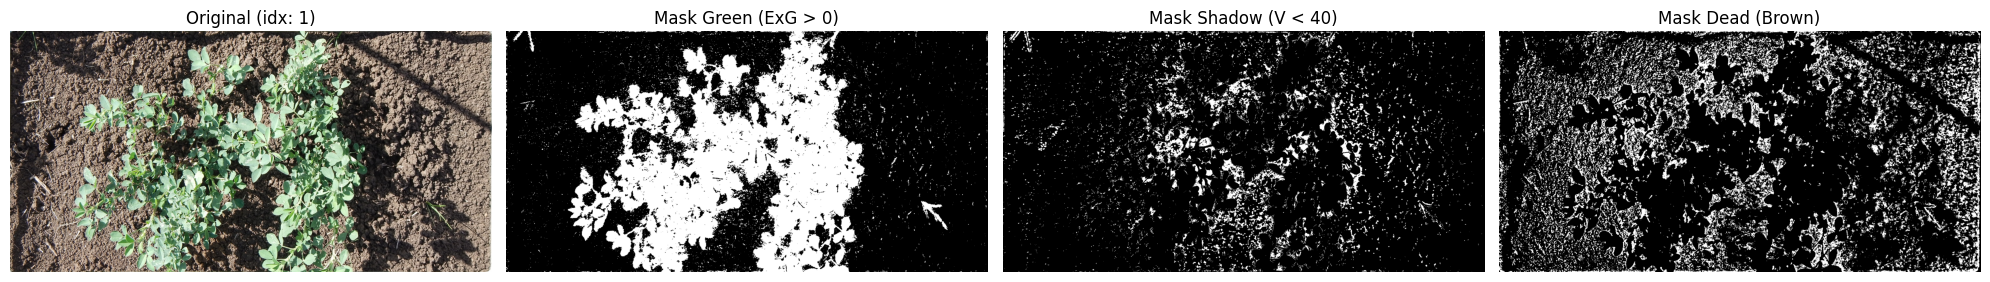

In [15]:
image_masks_plot(1)

### mask_green 임계값 비교

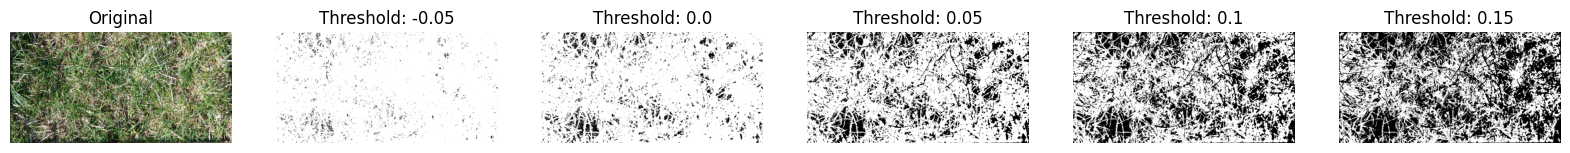

In [24]:
def find_best_threshold(idx):
    # 1. 이미지 가져오기
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    # 2. ExG 계산
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 3. 테스트할 임계값 리스트 (조금씩 높여가며 테스트)
    thresholds = [-0.05, 0.0, 0.05, 0.1, 0.15]

    plt.figure(figsize=(20, 4))

    # 원본 먼저 보여주기
    plt.subplot(1, len(thresholds)+1, 1)
    plt.imshow(img_raw)
    plt.title("Original")
    plt.axis('off')

    # 각 임계값 적용 결과 보여주기
    for i, thresh in enumerate(thresholds):
        _, mask = cv2.threshold(exg, thresh, 255, cv2.THRESH_BINARY)

        # 시각화 (흰색=풀, 검은색=배경)
        plt.subplot(1, len(thresholds)+1, i+2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Threshold: {thresh}")
        plt.axis('off')

    plt.show()

# 실행: 0번, 10번, 20번 이미지로 테스트해보세요
find_best_threshold(0)
# find_best_threshold(10)

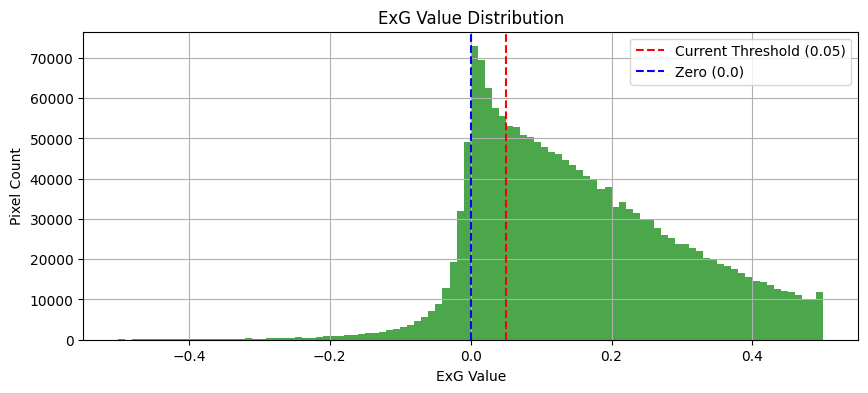

In [25]:
def plot_exg_histogram(idx):
    img_raw, img_norm, img_tex = get_images_for_viz(image_paths[idx])

    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    # 히스토그램 그리기
    plt.figure(figsize=(10, 4))
    plt.hist(exg.ravel(), bins=100, range=(-0.5, 0.5), color='green', alpha=0.7)
    plt.title("ExG Value Distribution")
    plt.xlabel("ExG Value")
    plt.ylabel("Pixel Count")
    plt.grid(True)

    # 0.05 위치 표시 (현재 설정값)
    plt.axvline(x=0.05, color='red', linestyle='--', label='Current Threshold (0.05)')
    plt.axvline(x=0.0, color='blue', linestyle='--', label='Zero (0.0)')
    plt.legend()
    plt.show()

plot_exg_histogram(0)

## 2-1. Mask - HSV, Lab 접근 함수

In [22]:
def compare_green_masks(idx):
    # 1. 이미지 로드
    path = image_paths[idx]
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # -----------------------------------------------------------
    # Method A: 기존 RGB (ExG)
    # -----------------------------------------------------------
    img_float = img_rgb.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True) + 1.0
    img_norm = img_float / sum_rgb
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b
    _, mask_exg = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY) # 임계값 조절 가능

    # -----------------------------------------------------------
    # Method B: HSV (Hue 기반)
    # -----------------------------------------------------------
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # 기존
    # 초록색 범위 (H: 35~85)
    # S: 25 이상 (너무 하얀 빛 반사 제외)
    # V: 25 이상 (너무 어두운 그림자 제외)

    # 수정
    # Hue 범위 확장 : 35~85 -> 25~95
    # Saturation 감소 : 25 -> 20
    # Value 감소 : 25 -> 20
    lower_green = np.array([25, 20, 20])
    upper_green = np.array([95, 255, 255])
    mask_hsv = cv2.inRange(hsv, lower_green, upper_green)

    # -----------------------------------------------------------
    # Method C: Lab (a channel 기반) - ★ 추천 ★
    # -----------------------------------------------------------
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b_channel = cv2.split(lab)

    # 수정
    # 그림자가 지면 노란색 기운이 빠지고 회색에 가까워짐
    # b > 130 (진한 노란끼) -> b > 120 (약한 노란끼도 허용)
    # a < 125 (초록끼) ->  a < 127 (약한 초록끼도 허용)

    mask_lab = cv2.inRange(lab, (0, 0, 120), (255, 127, 255))

    # -----------------------------------------------------------
    # Method D: CLAHE + Lab (★ 강력 추천 ★)
    # 이미지를 밝게 평탄화시킨 후 Lab 필터 적용
    # -----------------------------------------------------------
    l, a, b_channel = cv2.split(lab)

    # CLAHE 생성 (대비 제한 적응형 히스토그램 평활화)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l) # 밝기(L) 채널만 보정 (그림자 제거 효과)

    # 보정된 L 채널로 새로운 Lab 이미지 합치기
    limg = cv2.merge((cl, a, b_channel))

    # 똑같은 Lab 기준으로 마스킹 (이제 그림자가 밝아졌으므로 더 잘 잡힘)
    mask_clahe = cv2.inRange(limg, (0, 0, 120), (255, 127, 255))


    # -----------------------------------------------------------
    # 시각화
    # -----------------------------------------------------------
    fig = plt.figure(figsize=(20, 6))

    # (1) 원본
    plt.subplot(1, 5, 1)
    plt.imshow(img_rgb)
    plt.title(f"Original (idx: {idx})")
    plt.axis('off')

    # (2) RGB (ExG)
    plt.subplot(1, 5, 2)
    plt.imshow(mask_exg, cmap='gray')
    plt.title("1. RGB (ExG)\nSensitive to Light")
    plt.axis('off')

    # (3) HSV
    plt.subplot(1, 5, 3)
    plt.imshow(mask_hsv, cmap='gray')
    plt.title("2. HSV\n(Hue 35~85)")
    plt.axis('off')

    # (4) Lab
    plt.subplot(1, 5, 4)
    plt.imshow(mask_lab, cmap='gray')
    plt.title("3. Lab\n(a < 125 & b > 130)")
    plt.axis('off')

    # (5) CLAHE + Lab
    plt.subplot(1,5,5)
    plt.imshow(mask_clahe, cmap='gray')
    plt.title("3. CLAHE + Lab\n(Lighting Corrected) ★")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)

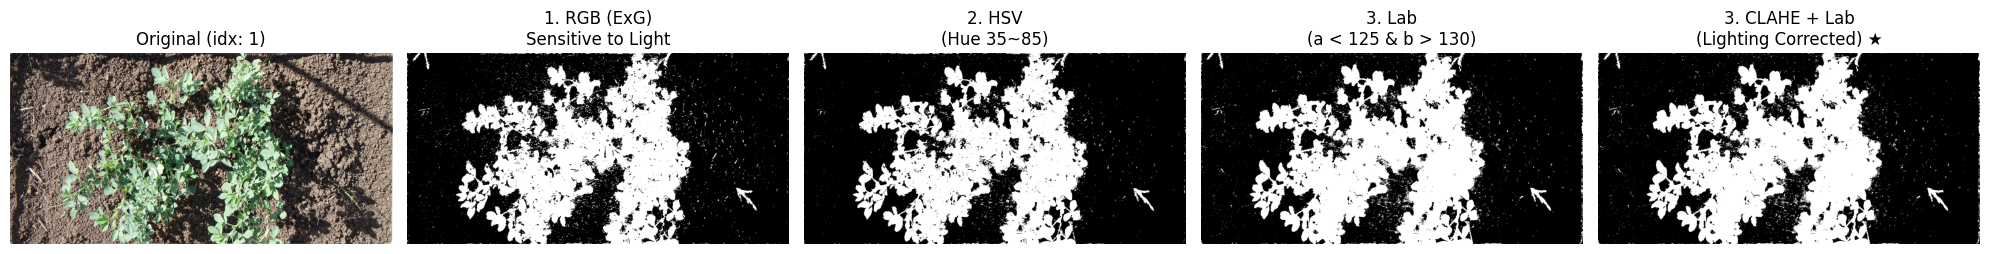

In [23]:
compare_green_masks(1)

## 3. 특징 추출

### 3-1. 면적 계산 및 식생 지수

In [68]:
def get_advanced_biomass_features(path, image_id):
    # 1. 이미지 로드
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


    # ---------------------------------------------------------
    # [전처리] Img_Norm (정규화된 RGB) - 조명 영향 제거
    # ---------------------------------------------------------
    img_float = img_rgb.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True) + 1e-8
    img_norm = img_float / sum_rgb

    # ---------------------------------------------------------
    # [마스크 생성] Mask_Green, Mask_Dead, Mask_Shadow
    # ---------------------------------------------------------

    # 1. Mask_Green (ExG 활용)
    r, g, b = cv2.split(img_norm)
    exg = 2*g - r - b

    _, mask_green = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)

    # 2. Mask_Dead (HSV 활용: 노랑~갈색)
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    # H: 15~35 (갈색), S: 20이상, V: 20이상 -> 상황에 따라 튜닝 필요
    mask_dead = cv2.inRange(hsv, (15, 20, 20), (35, 255, 255))

    # 3. Mask_Shadow (그림자)
    # V(밝기)가 40 미만인 아주 어두운 영역
    mask_shadow_raw = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40))

    # [Shadow_Green_Ratio용] 식물 근처의 그림자만 추출 (교집합)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_green_dilated = cv2.dilate(mask_green, kernel, iterations=1) # 식물 영역 확장
    mask_shadow_on_plant = cv2.bitwise_and(mask_shadow_raw, mask_green_dilated)

    # ---------------------------------------------------------
    # [특징 추출] 결과 딕셔너리 생성
    # ---------------------------------------------------------
    features = {'image': image_id} # 나중에 merge를 위해 키값 저장

    # 픽셀 수 계산
    # ★ 여기서 mask_green을 사용하므로, 위에서 반드시 정의되어 있어야 합니다.
    green_count = cv2.countNonZero(mask_green)
    dead_count = cv2.countNonZero(mask_dead)
    shadow_count = cv2.countNonZero(mask_shadow_on_plant)

    # === A. 면적 계산 ===
    # Target: GDM_g, Dry_Green_g
    features['Green_Pixel_Count'] = green_count

    # Target: Dry_Dead_g
    features['Dead_Pixel_Count'] = dead_count

    # Target: Height, Dry_Total_g
    # Mask_Green 대비 그림자 비율
    if green_count > 0:
        features['Shadow_Green_Ratio'] = shadow_count / green_count
    else:
        features['Shadow_Green_Ratio'] = 0.0

    # === B. 식생 지수 (NDVI 예측용) ===
    if green_count > 0:
        # Mask_Green 영역 내부의 정규화된 g 값의 평균
        features['Avg_Greenness'] = cv2.mean(g, mask=mask_green)[0]

        # Mask_Green 영역 내부의 ExG 값 평균
        features['Avg_ExG'] = cv2.mean(exg, mask=mask_green)[0]
    else:
        features['Avg_Greenness'] = 0.0
        features['Avg_ExG'] = 0.0

    return features

In [70]:
# 1. 결과를 담을 리스트
unique_images_df = df_train_raw[['image_path']].drop_duplicates()

extracted_features_list = []
error_count = 0

print("이미지 특징 추출 시작...")

# 2. tqdm을 이용해 전체 데이터 순회
for idx, row in tqdm(unique_images_df.iterrows(), total=len(unique_images_df)):

    # # 이미지 파일명 가져오기 (컬럼명이 'image'가 아니면 수정 필요)
    # img_name = row['image_path']

    # # 전체 경로 만들기
    # full_path = os.path.join(train_img_dir, img_name)

    # # 함수 실행
    # feats = get_advanced_biomass_features(full_path, img_name)


    # 1. 경로를 여기서 만듭니다.
    img_name = os.path.basename(str(row['image_path']))
    full_path = os.path.join(train_img_dir, img_name)

    # 2. 만든 경로(full_path)를 함수에 던져줍니다.
    # 함수 정의의 'path' 자리에 'full_path' 값이 들어갑니다.
    feats = get_advanced_biomass_features(full_path, img_name)

    if feats is not None:
        extracted_features_list.append(feats)
    else:
        error_count += 1

print(f"\n추출 완료! (성공: {len(extracted_features_list)}, 실패/이미지없음: {error_count})")

# 3. 리스트를 데이터프레임으로 변환
df_img_features = pd.DataFrame(extracted_features_list)

cols = ['image', 'Green_Pixel_Count', 'Dead_Pixel_Count', 'Shadow_Green_Ratio', 'Avg_Greenness', 'Avg_ExG']
available_cols = [c for c in cols if c in df_img_features.columns]
df_img_features = df_img_features[available_cols]

# 5. 결과 확인
print("최종 데이터 크기:", df_img_features.shape)
display(df_img_features.head())

# 6. CSV 저장
# 원본과 합치지 않은 순수한 특징 파일입니다.
save_path = os.path.join(root_path, 'train_features_only.csv')
df_img_features.to_csv(save_path, index=False)

print(f"저장 완료: {save_path}")

이미지 특징 추출 시작...


100%|██████████| 357/357 [00:53<00:00,  6.73it/s]


추출 완료! (성공: 357, 실패/이미지없음: 0)
최종 데이터 크기: (357, 6)


,image,Green_Pixel_Count,Dead_Pixel_Count,Shadow_Green_Ratio,Avg_Greenness,Avg_ExG
0,ID1011485656.jpg,1509676,655268,0.127595,0.431608,0.294824
1,ID1012260530.jpg,650761,444354,0.238525,0.403816,0.211449
2,ID1025234388.jpg,557467,403793,0.257456,0.434219,0.302657
3,ID1028611175.jpg,1751484,600214,0.066516,0.466839,0.400517
4,ID1035947949.jpg,1787677,1450352,0.066803,0.422606,0.267818


저장 완료: /content/drive/MyDrive/Kaggle/csiro-biomass/train_features_only.csv


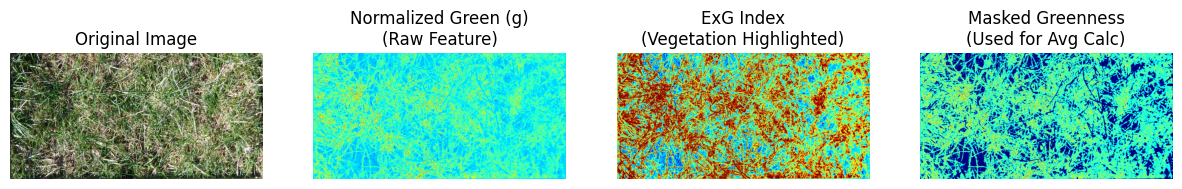

[ID1011485656.jpg]
Calculated Avg_Greenness: 0.4316
Calculated Avg_ExG:       0.2948


In [71]:
def visualize_ndvi_features(idx):
    # 1. 이미지 로드
    row = unique_images_df.iloc[idx]
    img_name = os.path.basename(str(row['image_path']))
    full_path = os.path.join(train_img_dir, img_name)

    img_bgr = cv2.imread(full_path)
    if img_bgr is None: return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. 정규화 (Img_Norm)
    img_float = img_rgb.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True) + 1e-8
    img_norm = img_float / sum_rgb

    r, g, b = cv2.split(img_norm) # 여기서 g가 'Avg_Greenness'의 재료입니다.
    exg = 2*g - r - b             # 여기가 'Avg_ExG'의 재료입니다.

    # 3. 마스크 생성
    _, mask_green = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY)

    # 4. 시각화
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(g, cmap='jet') # 파란색(낮음) -> 빨간색(높음)
    plt.title("Normalized Green (g)\n(Raw Feature)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(exg, cmap='jet', vmin=-0.2, vmax=0.4)
    plt.title("ExG Index\n(Vegetation Highlighted)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    # 마스크를 씌워서 '진짜 계산되는 영역'만 보여줌
    masked_g = cv2.bitwise_and(g, g, mask=mask_green.astype(np.uint8))
    plt.imshow(masked_g, cmap='jet')
    plt.title("Masked Greenness\n(Used for Avg Calc)")
    plt.axis('off')

    plt.show()

    # 실제 계산값 출력
    val_g = cv2.mean(g, mask=mask_green.astype(np.uint8))[0]
    val_exg = cv2.mean(exg, mask=mask_green.astype(np.uint8))[0]
    print(f"[{img_name}]")
    print(f"Calculated Avg_Greenness: {val_g:.4f}")
    print(f"Calculated Avg_ExG:       {val_exg:.4f}")

# 실행 (0번 이미지로 확인)
visualize_ndvi_features(0)

### NGRDI 부분 추가 버전 (임시)

In [72]:
def get_advanced_biomass_features(image_path, image_id):
    # 1. 이미지 로드
    if not os.path.exists(image_path):
        return None

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # ---------------------------------------------------------
    # [전처리] Img_Norm (정규화된 RGB)
    # ---------------------------------------------------------
    img_float = img_rgb.astype(np.float32)
    sum_rgb = np.sum(img_float, axis=2, keepdims=True) + 1e-8
    img_norm = img_float / sum_rgb

    # 채널 분리 (R, G, B)
    r_norm, g_norm, b_norm = cv2.split(img_norm) # 정규화된 값

    # (주의: NGRDI 계산을 위해 정규화되지 않은 원본 float 값도 분리)
    r_raw = img_float[:, :, 0]
    g_raw = img_float[:, :, 1]

    # ---------------------------------------------------------
    # [지수 계산] ExG & NGRDI
    # ---------------------------------------------------------
    # 1. ExG (Excess Green) -> 마스크 생성용으로 사용
    exg = 2*g_norm - r_norm - b_norm

    # 2. NGRDI (Normalized Green Red Difference Index) -> 추가 피처용
    # 공식: (G - R) / (G + R)
    # 분모 0 방지
    ngrdi = (g_raw - r_raw) / (g_raw + r_raw + 1e-8)

    # ---------------------------------------------------------
    # [마스크 생성]
    # ---------------------------------------------------------
    # 1. Mask_Green (ExG 기준 0.05 이상)
    _, mask_green = cv2.threshold(exg, 0.05, 255, cv2.THRESH_BINARY)
    mask_green = mask_green.astype(np.uint8)

    # 2. Mask_Dead (HSV 활용)
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    mask_dead = cv2.inRange(hsv, (15, 20, 20), (35, 255, 255))

    # 3. Mask_Shadow (그림자)
    mask_shadow_raw = cv2.inRange(hsv, (0, 0, 0), (180, 255, 40))

    # 식물 근처 그림자 추출
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_green_dilated = cv2.dilate(mask_green, kernel, iterations=1)
    mask_shadow_on_plant = cv2.bitwise_and(mask_shadow_raw, mask_green_dilated)

    # ---------------------------------------------------------
    # [특징 추출] 결과 저장
    # ---------------------------------------------------------
    features = {'image': image_id}

    green_count = cv2.countNonZero(mask_green)
    dead_count = cv2.countNonZero(mask_dead)
    shadow_count = cv2.countNonZero(mask_shadow_on_plant)

    features['Green_Pixel_Count'] = green_count
    features['Dead_Pixel_Count'] = dead_count

    # 그림자 비율
    if green_count > 0:
        features['Shadow_Green_Ratio'] = shadow_count / green_count
    else:
        features['Shadow_Green_Ratio'] = 0.0

    # 식생 지수 평균 (Avg_Greenness, Avg_ExG, Avg_NGRDI)
    if green_count > 0:
        # 1. Avg_Greenness (순수 초록색 정도)
        features['Avg_Greenness'] = cv2.mean(g_norm, mask=mask_green)[0]

        # 2. Avg_ExG (초록 강조 지수)
        features['Avg_ExG'] = cv2.mean(exg, mask=mask_green)[0]

        # 3. Avg_NGRDI (추가된 부분!)
        features['Avg_NGRDI'] = cv2.mean(ngrdi, mask=mask_green)[0]

    else:
        features['Avg_Greenness'] = 0.0
        features['Avg_ExG'] = 0.0
        features['Avg_NGRDI'] = 0.0 # 풀이 없으면 0

    return features

In [73]:
# 1. 중복 제거
unique_images_df = df_train_raw[['image_path']].drop_duplicates()

extracted_features_list = []
error_count = 0

print(f"이미지 특징 추출 시작... (대상 폴더: {train_img_dir})")

# 2. 반복문 실행
for idx, row in tqdm(unique_images_df.iterrows(), total=len(unique_images_df)):

    # 파일명 추출 및 경로 생성
    raw_path_str = str(row['image_path'])
    img_name = os.path.basename(raw_path_str)
    full_path = os.path.join(train_img_dir, img_name)

    # 함수 실행
    feats = get_advanced_biomass_features(full_path, img_name)

    if feats is not None:
        extracted_features_list.append(feats)
    else:
        error_count += 1

print(f"\n추출 완료! (성공: {len(extracted_features_list)}, 실패: {error_count})")

# 3. CSV로 저장
if extracted_features_list:
    df_features_only = pd.DataFrame(extracted_features_list)

    # 컬럼 정리 (Avg_NGRDI 추가됨)
    cols = ['image', 'Green_Pixel_Count', 'Dead_Pixel_Count', 'Shadow_Green_Ratio', 'Avg_Greenness', 'Avg_ExG', 'Avg_NGRDI']
    final_cols = [c for c in cols if c in df_features_only.columns]
    df_features_only = df_features_only[final_cols]

    save_path = os.path.join(root_path, 'train_features_only.csv')
    df_features_only.to_csv(save_path, index=False)

    print(f"✅ 저장 완료: {save_path}")
    print("데이터 미리보기:")
    display(df_features_only.head())

이미지 특징 추출 시작... (대상 폴더: /content/drive/MyDrive/Kaggle/csiro-biomass/train)


100%|██████████| 357/357 [00:57<00:00,  6.25it/s]


추출 완료! (성공: 357, 실패: 0)
✅ 저장 완료: /content/drive/MyDrive/Kaggle/csiro-biomass/train_features_only.csv
데이터 미리보기:


,image,Green_Pixel_Count,Dead_Pixel_Count,Shadow_Green_Ratio,Avg_Greenness,Avg_ExG,Avg_NGRDI
0,ID1011485656.jpg,1509676,655268,0.127595,0.431608,0.294824,0.106150
1,ID1012260530.jpg,650761,444354,0.238525,0.403816,0.211449,0.116363
2,ID1025234388.jpg,557467,403793,0.257456,0.434219,0.302657,0.128977
3,ID1028611175.jpg,1751484,600214,0.066516,0.466839,0.400517,0.120469
4,ID1035947949.jpg,1787677,1450352,0.066803,0.422606,0.267818,0.016525


---

## C. 형태 및 질감 (Morphology) - Species & Height 예측용
Source: Img_Tex (CLAHE 적용됨) + Mask_Green (배경 제외용)

### i. Roughness (거칠기)
- Action: GLCM(Gray-Level Co-occurrence Matrix) 계산 $\rightarrow$ Contrast, Energy.
- $\rightarrow$ Target: $Height\_Ave\_cm$ (키가 클수록 거칠고 복잡함)

In [ ]:
glcm = graycomatrix(img_tex, distances=[1], angles=[0, np.pi/2], levels=256, symmetric=True, normed=True)
features['Texture_Contrast'] = graycoprops(glcm, 'contrast').mean()
features['Texture_Energy'] = graycoprops(glcm, 'energy').mean()

### ii. Clover Score (둥근 정도)
- Action 1 (Opening): Mask_Green에 큰 원형 커널로 Morphological Opening 적용 $\rightarrow$ 살아남은 면적 비율 계산. (풀은 사라지고 클로버만 남음)
- Action 2 (Blob): Blob Detection으로 검출된 원형 객체 수.
- $\rightarrow$ Target: $Dry\_Clover\_g$x

Morphological_Opening_Ratio (열림 연산 후 남은 면적 비율)

In [ ]:
# 1. Action 1: Morphological Opening (클로버 면적 비율)
# 둥근 커널을 사용하여 얇은 풀을 지워버림
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
opened_mask = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

plant_area = cv2.countNonZero(mask_green) # 전체 식물 면적
clover_area = cv2.countNonZero(opened_mask) # 풀 지우고 남은 면적

# 0으로 나누기 방지
if plant_area == 0:
    clover_area_ratio = 0
else:
    clover_area_ratio = clover_area / plant_area

In [ ]:
# 2. Action 2: Blob Detection (클로버 덩어리 개수)
# img_tex: CLAHE가 적용된 Grayscale 이미지 (Step 2에서 생성한 Img_Tex)

def get_blob_count(img_gray):
    # 1. Blob Detector 파라미터 설정
    params = cv2.SimpleBlobDetector_Params()

    # (1) Threshold (임계값) 설정
    # 이미지가 어두운 곳~밝은 곳 다양하므로 범위를 넓게 잡습니다.
    params.minThreshold = 10
    params.maxThreshold = 220

    # (2) Area (면적) 필터
    # 너무 작은 점(노이즈)이나 화면을 꽉 채우는 건 무시
    params.filterByArea = True
    params.minArea = 50      # 픽셀 단위 (이미지 해상도에 따라 조절 필요)
    params.maxArea = 5000

    # (3) Circularity (원형도) 필터 - 가장 중요! ★
    # 1에 가까울수록 완벽한 원. 풀은 길쭉해서 이 값이 낮음.
    params.filterByCircularity = True
    params.minCircularity = 0.3  # 클로버 잎은 불규칙한 원형이므로 0.3~0.5 정도

    # (4) Convexity (볼록도) 필터
    # 잎은 대체로 볼록함
    params.filterByConvexity = True
    params.minConvexity = 0.2

    # (5) Inertia (관성) 필터
    # 길쭉한지 둥근지 판단. 0에 가까우면 직선, 1에 가까우면 원.
    params.filterByInertia = True
    params.minInertiaRatio = 0.1 # 풀(직선)을 거르기 위한 최소한의 장치

    # 2. Detector 생성 및 감지
    detector = cv2.SimpleBlobDetector_create(params)

    # 키포인트(감지된 Blob들) 추출
    # 입력: CLAHE 적용된 Grayscale 이미지 (img_tex)
    keypoints = detector.detect(img_gray)

    # 3. 결과 반환 (감지된 Blob의 개수)
    return len(keypoints)

num_blobs = get_blob_count(img_tex)

### iii. Grass Score (선형 정도)
- Action 1 (Edges): Canny Edge Detection $\rightarrow$ Hough Line Transform $\rightarrow$ 검출된 직선의 총 길이.
- Action 2 (HOG): HOG 특징 추출 $\rightarrow$ 특정 방향(수직/수평)의 히스토그램 강도 합계.
- $\rightarrow$ Target: $Dry\_Green\_g$

HOG_Edge_Strength (직선 에지 강도)

In [ ]:
# 1. Canny Edge Detection (에지 검출)
def get_grass_line_length(img_gray):
    # img_gray: CLAHE가 적용된 Grayscale 이미지 (img_tex)
    # 50, 150: 임계값 (상황에 따라 조절 가능하지만 50~150이 무난함)
    edges = cv2.Canny(img_gray, 50, 150)

    # 2. Hough Lines P (확률적 허프 변환) - 직선 찾기
    # minLineLength: 이 길이보다 짧은 선은 무시 (잡음 제거, 풀잎처럼 긴 것만 찾음)
    # maxLineGap: 선이 중간에 살짝 끊겨도 이 픽셀 이하면 같은 선으로 간주
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                            minLineLength=30, maxLineGap=10)

    total_length = 0

    # 3. 검출된 직선들의 길이 합산
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # 유클리드 거리 공식 (직선 길이)
            length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            total_length += length

    return total_length

In [ ]:
line_length_sum = get_grass_line_length(img_tex)

In [ ]:
# 2. Grass Score (HOG)
# HOG 특징 추출
f, _ = hog(img_tex, orientations=8, pixels_per_cell=(16, 16),
           cells_per_block=(1, 1), visualize=True)
# 풀이 많으면 특정 방향의 Gradient가 매우 셈 -> Max값 혹은 분산 사용
hog_strength = np.mean(f) # 또는 np.max(f)

# IV. 최종 가설 검증 (Validation with Train Labels)

## A. Green_Pixel_Count vs GDM_g: 선형 비례 관계인가?

## B. Dead_Pixel_Count vs Dry_Dead_g: 양의 상관관계인가?

## C. Roughness + Green_Shadow_Ratio vs Height_Ave_cm: 상관관계가 있는가?

## D. Species 구분 검증:
- Train Set의 Species 컬럼을 활용.

- Pure Clover 이미지들의 Clover Score가 높게 나오는지?

- Pure Grass 이미지들의 Grass Score가 높게 나오는지?